In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import LTransform as LT
from get_utils import get_hidden, get_dir
from pathlib import Path
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
import pandas as pd
import PcmPy as pcm
from scipy.spatial.distance import pdist, squareform
import seaborn as sb
import scipy.stats as stats

In [114]:
# Load hidden
folder_name = 'Sim_all_inv'
n_latent = 2
n_muscle = 6
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8,-8]}
ff_coef = [0,8,0,8,-8]

results = pd.DataFrame()
rdms = []

for mn in range(0,20):
    model_name = "model{:02d}".format(mn)

    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    U, S, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle] # output potent
    N = V[:,n_muscle:] # output null

    data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)

    # Apply PCA
    Data_prep =  {'x_ld':[],'x':[]}
    for i in range(len(data)):
        X = data[i]

       
        #if i==0:
        mean_dat = np.mean(X,axis=0,keepdims=True)
        X = X-mean_dat
        #norm_dat = np.linalg.norm(X,axis=0,keepdims=True)
        norm_dat = np.linalg.norm(X.reshape(8*100,-1),axis=0,keepdims=True)[:,None,:]
        X = X/norm_dat


        #X = X@P
        #X = X@N

        if i==0:
            T = LT.Transform(num_latent=n_latent)
            T.fit(X,method='PCA')        
            
        x_ld = T.transform(X,ensure_orthogonality=True)

        Data_prep['x_ld'].append(x_ld)
        Data_prep['x'].append(X)

    rdm = []

    for k,s in enumerate(['x']): # ,'x_ld'
        D = np.stack(Data_prep[s])
        dist = np.zeros((10,100))
        for i in range(100):
            activity = D[:,:,i,:]
            dims = activity.shape
            activity = activity.reshape(dims[0],-1)
            dist[:,i] = pdist(activity)
        rdm.append(dist)
    rdms.append(rdm[0])

# plot MDS

T-statistic: 2.312122481173112
P-value: 0.032143299913173135


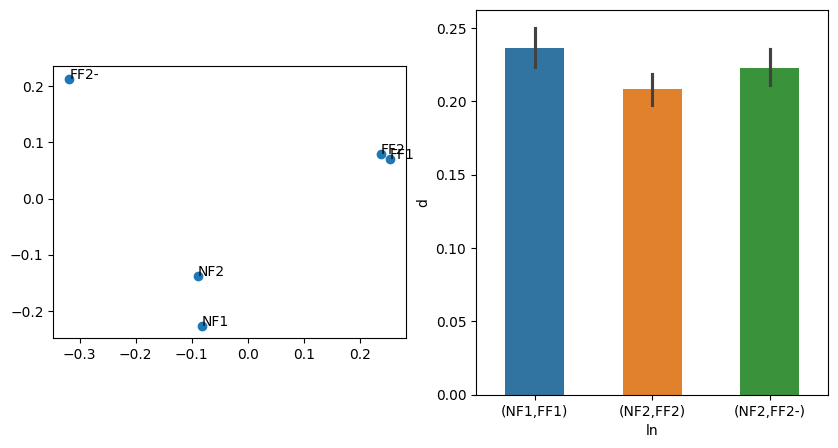

In [120]:
tp = np.arange(18)
labels = ['NF1','FF1','NF2','FF2','FF2-']

if tp is int:
    rdm_avg = np.mean(np.stack(rdms,axis=0)[:,:,tp],axis=0)
else:
    rdm_avg = np.mean(np.mean(np.stack(rdms,axis=0)[:,:,tp],axis=0),axis=1)

rdm_m = squareform(rdm_avg)

n_cond = rdm_m.shape[0]

H = np.eye(n_cond) - np.ones((n_cond,n_cond))/n_cond
G = -0.5*H@rdm_m@H

# np.sum(pcm.G_to_dist(G)-rdm_m) # sanity check
W,Glam = pcm.classical_mds(G)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(W[:,0],W[:,1])
for i, label in enumerate(labels):
    ax[0].annotate(label,(W[i,0],W[i,1]))
ax[0].set_aspect('equal')


T = pd.DataFrame()

label = ['(NF1,FF1)','(NF1,NF2)','(NF1,FF2)','(NF1,FF2-)','(FF1,NF2)','(FF1,FF2)','(FF1,FF2-)','(NF2,FF2)','(NF2,FF2-)','(FF2,FF2-)']
select = [0,7,8]

for i in range(len(rdms)):
    for j in select:
        if tp is int:
            d = {'m':[i],'ln':[label[j]],'d':[rdms[i][j,tp]]}
        else:
            avg_dist = np.mean(rdms[i][j,tp])
            d = {'m':[i],'ln':[label[j]],'d':[avg_dist]}
        T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)
ax[1] = sb.barplot(x='ln',y='d',data=T,hue='ln',width=0.5) # ,order=ho,palette=color ,hue_order=ho

sample1 = T.d[T.ln == '(NF1,FF1)'].to_numpy()
sample2 = T.d[T.ln == '(NF2,FF2)'].to_numpy()
sample3 = T.d[T.ln == '(NF2,FF2-)'].to_numpy()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample3, sample2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 2.8392314529841682
P-value: 0.01048635043103869
